In [757]:
import numpy as np
import pandas 
import pandas as pd
from elasticsearch import Elasticsearch
import json

In [758]:
# create a client instance of the library
elastic_client = Elasticsearch()



In [759]:
# Define config and query parameters
datalist = []
timelist = []
humilist = []
windlist = []
rainlist = []

host = "127.0.0.1"
port = 9200
timeout = 1000
index = "weather"
doc_type = "items"
time_to_search = "2019-12-31T23:59:00"
to_date        = "2019-12-03T07:00:00"
weather_source = "meteo.gr"
size = 10000



body={"from": 0, "size": 10000,"query": {
    "bool": {
      "must": [
        {"range": {
            "time": {
                "lte": time_to_search
                
                
            }        
            }
        },
        {"term": {
             "source": weather_source
         }
        }]}
    }
  }

# Init Elasticsearch instance
es = Elasticsearch(
    [
        {
            'host': host,
            'port': port
        }
    ],
    timeout=timeout
)


# Process hits here
def process_hits(hits):
    #for item in hits:
    for key, val in hits["hits"].items():
        if key == "hits":
            for num, doc in enumerate(val):
                #if (exists = doc["_source"]["time"] in timelist): 
                #print (num, '-->', doc["_source"]["temperature"], "\n")
                datalist.append(doc["_source"]["temperature"])
                timelist.append(doc["_source"]["time"])

    #print(json.dumps(item, indent=2))



# Check index exists
if not es.indices.exists(index=index):
    print("Index " + index + " not exists")
    exit()

# Init scroll by search
data = es.search(
    index=index,
    doc_type=doc_type,
    scroll='2m',
    size=size,
    body=body
)

# Get the scroll ID
sid = data['_scroll_id']
scroll_size = len(data['hits']['hits'])

while scroll_size > 0:
    
    "Scrolling..."
    
    # Before scroll, process current batch of hits
    process_hits(data)
    
    data = es.scroll(scroll_id=sid, scroll='2m')

    # Update the scroll ID
    sid = data['_scroll_id']
    

    # Get the number of results that returned in the last scroll
    scroll_size = len(data['hits']['hits'])
    
    




C:\ProgramData\Anaconda3\lib\site-packages\elasticsearch\connection\base.py:190: ElasticsearchDeprecationWarning: [types removal] Specifying types in search requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


In [760]:
dataset = pd.DataFrame({"temperature":datalist,"time":timelist}) 

dataset['time'] = pd.to_datetime(dataset['time'], utc=True)
dataset = (dataset.assign(d=dataset['time'].dt.date,
                 t=dataset['time'].dt.time)
         .sort_values(['d','t'], ascending=[True, True])
         .drop(['d','t'], axis=1))

dataset.sort_values(by="time")
list_temperature =dataset['temperature'].values
list_datetime    =dataset['time'].values 
dataset = pd.DataFrame({"temperature":list_temperature,"time":list_datetime}) 
dataset

,temperature,time
0,1.8,2014-12-31 22:00:00
1,1.8,2014-12-31 22:10:00
2,1.8,2014-12-31 22:20:00
3,1.9,2014-12-31 22:30:00
4,1.8,2014-12-31 22:40:00
...,...,...
262939,0.3,2019-12-31 21:10:00
262940,0.4,2019-12-31 21:20:00
262941,0.5,2019-12-31 21:30:00
262942,0.6,2019-12-31 21:40:00


In [761]:
import tensorflow as tf



In [762]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers import LeakyReLU
from numpy.random import seed
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


seed(1)
tf.random.set_seed(1)

#dataset['temperature'] = medfilt(dataset['temperature'], 3)
#dataset['temperature'] = gaussian_filter1d(dataset['temperature'], 1.2)

temperature_df = dataset[['temperature']]
temperature_df

,temperature
0,1.8
1,1.8
2,1.8
3,1.9
4,1.8
...,...
262939,0.3
262940,0.4
262941,0.5
262942,0.6


In [763]:
train_split= 0.8
split_idx = int(len(temperature_df) * 0.8)
training_set = temperature_df[:split_idx].values
test_set = temperature_df[split_idx:].values

sc = MinMaxScaler(feature_range = (0, 1))
#training_set = sc.fit_transform(training_set)
#test_set = sc.fit_transform(test_set)


In [764]:
# 5-observations prediction using 30 days data
x_train = []
y_train = []
n_future = 1 #Next 5 observations temperature forecast
n_past = 26 #Past 30 observations
for i in range(0, len(training_set) - n_past - n_future + 1):
    x_train.append(training_set[i : i + n_past, 0])
    y_train.append(training_set[i + n_past : i + n_past + n_future, 0])
x_train


[array([1.8, 1.8, 1.8, 1.9, 1.8, 1.8, 1.9, 1.8, 1.8, 1.8, 1.9, 2.1, 2. ,
        2. , 2.1, 2.1, 2.1, 2. , 1.9, 1.9, 1.8, 1.9, 1.8, 1.9, 1.9, 1.9]),
 array([1.8, 1.8, 1.9, 1.8, 1.8, 1.9, 1.8, 1.8, 1.8, 1.9, 2.1, 2. , 2. ,
        2.1, 2.1, 2.1, 2. , 1.9, 1.9, 1.8, 1.9, 1.8, 1.9, 1.9, 1.9, 1.8]),
 array([1.8, 1.9, 1.8, 1.8, 1.9, 1.8, 1.8, 1.8, 1.9, 2.1, 2. , 2. , 2.1,
        2.1, 2.1, 2. , 1.9, 1.9, 1.8, 1.9, 1.8, 1.9, 1.9, 1.9, 1.8, 1.8]),
 array([1.9, 1.8, 1.8, 1.9, 1.8, 1.8, 1.8, 1.9, 2.1, 2. , 2. , 2.1, 2.1,
        2.1, 2. , 1.9, 1.9, 1.8, 1.9, 1.8, 1.9, 1.9, 1.9, 1.8, 1.8, 1.7]),
 array([1.8, 1.8, 1.9, 1.8, 1.8, 1.8, 1.9, 2.1, 2. , 2. , 2.1, 2.1, 2.1,
        2. , 1.9, 1.9, 1.8, 1.9, 1.8, 1.9, 1.9, 1.9, 1.8, 1.8, 1.7, 1.4]),
 array([1.8, 1.9, 1.8, 1.8, 1.8, 1.9, 2.1, 2. , 2. , 2.1, 2.1, 2.1, 2. ,
        1.9, 1.9, 1.8, 1.9, 1.8, 1.9, 1.9, 1.9, 1.8, 1.8, 1.7, 1.4, 1.3]),
 array([1.9, 1.8, 1.8, 1.8, 1.9, 2.1, 2. , 2. , 2.1, 2.1, 2.1, 2. , 1.9,
        1.9, 1.8, 1.9, 1.8, 1.9, 1.9, 1

In [765]:
x_train , y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1))

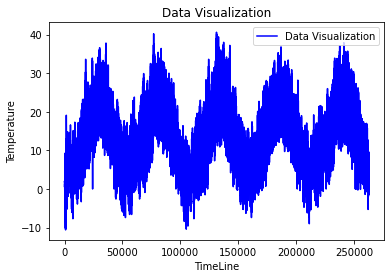

In [766]:
x_axis = range(len(temperature_df.values))
plt.figure()
plt.plot(x_axis, temperature_df.values, "b", label="Data Visualization")

plt.title("Data Visualization")
plt.xlabel("TimeLine")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [767]:
#SGD  RMSprop Adam Adadelta Adagrad Adamax Nadam Ftrl 
EPOCHS =20
BATCH_SIZE= 1024
UNITS = n_past
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=UNITS, activation='elu',  return_sequences=True, input_shape = (x_train.shape[1], 1))))
regressor.add(LSTM(units= UNITS, activation='elu'))
regressor.add(Dropout(0.1))#
#regressor.add(LSTM(units= UNITS, return_sequences=True))#
#regressor.add(Dropout(0.2))#
#regressor.add(LSTM(units= UNITS))
#regressor.add(Dropout(0.1))
regressor.add(Dense(units = n_future, activation='elu'))
regressor.compile(optimizer=tf.optimizers.Adam(                                      
                                       name='Adam'
                                       ), loss='mean_squared_error', metrics=['mean_squared_error'])
regressor.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
206/206 [==============================] - 57s 258ms/step - loss: 55.1082 - mean_squared_error: 55.1082
Epoch 2/20
206/206 [==============================] - 53s 257ms/step - loss: 3.5911 - mean_squared_error: 3.5911
Epoch 3/20
206/206 [==============================] - 53s 258ms/step - loss: 2.8092 - mean_squared_error: 2.8092
Epoch 4/20
206/206 [==============================] - 53s 258ms/step - loss: 2.3948 - mean_squared_error: 2.3948
Epoch 5/20
206/206 [==============================] - 53s 258ms/step - loss: 2.2239 - mean_squared_error: 2.2239
Epoch 6/20
206/206 [==============================] - 53s 259ms/step - loss: 2.1124 - mean_squared_error: 2.1124
Epoch 7/20
206/206 [==============================] - 53s 259ms/step - loss: 2.0588 - mean_squared_error: 2.0588
Epoch 8/20
206/206 [==============================] - 55s 265ms/step - loss: 2.0573 - mean_squared_error: 2.0573
Epoch 9/20
206/206 [==============================] - 55s 266ms/step - loss: 1.9480 - mean_squ

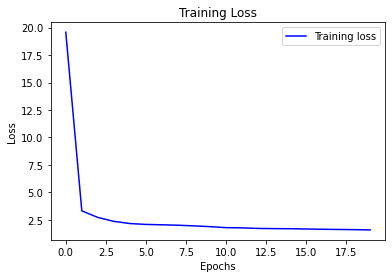

In [768]:
def visualize_loss(history, title):
    loss = history.history["loss"]
   
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(regressor.history, "Training Loss")

In [769]:
Train_loss = regressor.evaluate(x_train, y_train, verbose=0)

In [770]:
print("Loss:",Train_loss)

Loss: [0.5008971095085144, 0.5008971095085144]


In [771]:
x_test = test_set[: n_past, 0]
y_test = test_set[n_past : n_past + n_future, 0]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (1, x_test.shape[0], 1))
predicted_temperature = regressor.predict(x_test)
print('Predicted temperature {}'.format(predicted_temperature))
print('Real temperature {}'.format(y_test))


Predicted temperature [[2.2131855]]
Real temperature [2.2]


In [772]:
loss = regressor.evaluate(x_test, y_test, verbose=0)
print("Loss:",loss)

Loss: [0.0001738574355840683, 0.0001738574355840683]


In [773]:
def visualize_temerature_trend(prediction,real,range_val, title):
    prediction_val = prediction
    real_val       = real
    range_val = range_val
    plt.figure()
    plt.plot(range(range_val), prediction_val, "b", label="Prediction Distribution")
    plt.plot(range(range_val), real_val, "r", label="Real Temperature Distribution")
    plt.title(title)
    plt.xlabel("samples")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()


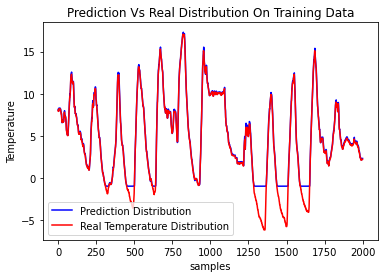

In [774]:
pre_values = []
real_values= []
look_back =2000
for i in range(look_back-1,-1,-1):
    last_observations =np.array(training_set[len(training_set)-n_past-1 -i : len(training_set) -1 -i])
    last_observations = np.reshape(last_observations, (1, last_observations.shape[0], 1))
    pre_values.append( regressor.predict(last_observations)[0])
   
    

visualize_temerature_trend(pre_values,training_set[-look_back:],look_back, "Prediction Vs Real Distribution On Training Data")

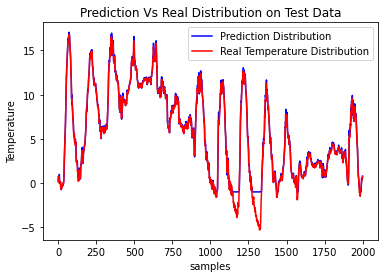

In [775]:
pre_values = []
real_values= []
look_back =2000
for i in range(look_back-1,-1,-1):
    last_observations =np.array(test_set[len(test_set)-n_past-1 -i : len(test_set) -1 -i])
    last_observations = np.reshape(last_observations, (1, last_observations.shape[0], 1))
    pre_values.append( regressor.predict(last_observations)[0])
   
    

visualize_temerature_trend(pre_values,test_set[-look_back:],look_back, "Prediction Vs Real Distribution on Test Data")

In [776]:
datalist_predict = []
timelist_predict = []
host = "127.0.0.1"
port = 9200
timeout = 1000
index = "weather"
doc_type = "items"
time_to_search = "now"
weather_source = "meteo.gr"
size = 1000



body={"from": 0, "size": 1000,"query": {
    "bool": {
      "must": [
        {"range": {
            "time": {
                "lte": time_to_search,
                "gte": time_to_search+"-1w"
                
                
                
            }        
            }
        },
        {"term": {
             "source": weather_source
         }
        }]}
    }
  }

# Init Elasticsearch instance
es = Elasticsearch(
    [
        {
            'host': host,
            'port': port
        }
    ],
    timeout=timeout
)

data = es.search(
    index=index,
    doc_type=doc_type,
    scroll='2m',
    size=size,
    body=body
)
for key, val in data["hits"].items():
        if key == "hits":
            for num, doc in enumerate(val):
                #if (exists = doc["_source"]["time"] in timelist): 
                #print (num, '-->', doc["_source"]["temperature"], "\n")
                datalist_predict.append(doc["_source"]["temperature"])
                timelist_predict.append(doc["_source"]["time"])



C:\ProgramData\Anaconda3\lib\site-packages\elasticsearch\connection\base.py:190: ElasticsearchDeprecationWarning: [types removal] Specifying types in search requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


In [777]:
dataset_predict = pd.DataFrame({"temperature":datalist_predict,"time":timelist_predict}) 

dataset_predict['time'] = pd.to_datetime(dataset_predict['time'], utc=True)
dataset_predict = (dataset_predict.assign(d=dataset_predict['time'].dt.date,
                 t=dataset_predict['time'].dt.time)
         .sort_values(['d','t'], ascending=[True, True])
         .drop(['d','t'], axis=1))

dataset_predict.sort_values(by="time")
list_temperature_predict =dataset_predict['temperature'].values
list_datetime_predict    =dataset_predict['time'].values 
dataset_predict = pd.DataFrame({"temperature":list_temperature_predict,"time":list_datetime_predict}) 
dataset_predict["temperature"].values[-n_past-1:]

array([ 3. ,  3.1,  3.8,  6.9,  7.5,  9.2,  9.6, 11.1, 13.3, 16.1, 16.7,
       16.6, 16.9, 16.2, 15.7, 16. , 16. , 16.4, 15.7, 15.2, 13.5, 12.6,
       11.9, 11.3, 11.6, 11.4, 10.8])

In [778]:
last_observations =np.array(dataset_predict["temperature"].values[-n_past-1:-1])
last_observations = np.reshape(last_observations, (1, last_observations.shape[0], 1))
predicted_temperature = regressor.predict(last_observations)
print('Predicted temperature {}'.format(predicted_temperature))
print('Real temperature {}'.format(dataset_predict["temperature"].values[-1:]))

Predicted temperature [[11.219759]]
Real temperature [10.8]


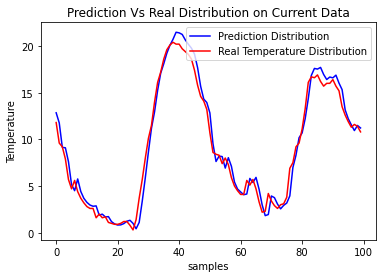

In [779]:
pre_values = []
real_values= []
look_back =100
for i in range(look_back-1,-1,-1):
    last_observations =np.array(dataset_predict["temperature"].values[len(dataset_predict["temperature"].values)-n_past-1 -i : len(dataset_predict["temperature"].values) -1 -i])
    last_observations
    last_observations = np.reshape(last_observations, (1, last_observations.shape[0], 1))
    #predicted_temperature = regressor.predict(last_observations)
    pre_values.append( regressor.predict(last_observations)[0])
   
    

visualize_temerature_trend(pre_values,dataset_predict["temperature"].values[-look_back:],look_back, "Prediction Vs Real Distribution on Current Data")